In [1]:
%matplotlib inline
%timeit

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import time
import pickle
import datetime
import re
import pyActigraphy

import sys
sys.path.append('/home/ngrav/project/')
from wearables.scripts import utils as wearutils
from wearables.scripts import data_v42 as weardata
from wearables.scripts import train_v42 as weartrain
from wearables.scripts import eval_v42 as weareval
from wearables.scripts import model as wearmodels
from wearables.scripts import DTW as weardtw

import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.spatial.distance import pdist, squareform
import fastdtw
import umap

plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=1
plt.rcParams['savefig.dpi'] = 600
sns.set_style("ticks")

In [64]:
# load data

model_fp = '/home/ngrav/project/wearables/model_zoo'

bst_trainer = os.path.join(model_fp, 'trainer_cnnv43l1l2_GA5.pkl')
bst_modelpkl = os.path.join(model_fp, '6143-cnnv43l1l2_GA5.pkl')


In [65]:
# # fix potential issue with net
net = wearmodels.CNN(2, 10080, 1, [(1, 32), (1, 64), (1, 128), (3, 256)])

# best CNN
_, md_model, trainer = weardtw.data_from_trainer(bst_trainer)

# fix issue with net
trainer.model = net

# call eval to get output, modify for return_hidden = True option
evaluation = weareval.eval_trained(trainer, split='train',
                                   modelpkl=bst_modelpkl,
                                   two_outputs=True)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


# fastdtw graph

1. D --> annoy --> clustering (unsupervised), then association with metadata
2. self-supervised embedding (~512dimensions) --> annoy based on D with various distance metrics OR DL based clustering, then association with metadata vs. GA association with metadata (otherwise, what is novel about the groups... do subclusters identify new interesting patients?)
3. 

In [4]:
from wearables.scripts import DTW as weardtw

In [61]:
# load previous
load = True

if load:
    # load it 
    with open('/home/ngrav/scratch/data_dtw.pkl', 'rb') as f:
        data_dtw = pickle.load(f)
        f.close()
else:
    # run it
    data_dtw = weardtw.rawdata_umap_dtw(bst_trainer)

    # since this takes so long, save it
    with open('/home/ngrav/scratch/data_dtw.pkl', 'wb') as f:
        pickle.dump(data_dtw, f, protocol=pickle.HIGHEST_PROTOCOL)
        f.close()

In [62]:
# rerun umap, forgot to return data
data_dtw['data_umap'] = weardtw.embed(data_dtw['D'])

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


In [63]:
data_umap = data_dtw['data_umap']
md = data_dtw['md']

In [66]:
# add model output 
md = md.merge(pd.Series(evaluation.yhat.numpy(), name='actigraphy-GA', index=evaluation.id), left_index=True, right_index=True, how='left')
md['AbsErr'] = np.abs(md['GA'] - md['actigraphy-GA'])

In [30]:
pfp = '/home/ngrav/project/wearables/results/'

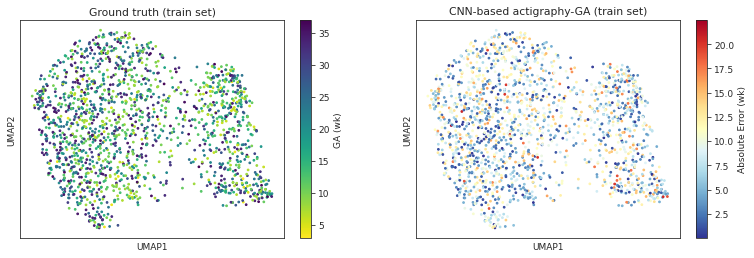

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
# ground truth
im = ax[0].scatter(data_umap[:, 0], data_umap[:, 1], 
                s=3,
                c=md['GA'], cmap='viridis_r')
fig.colorbar(im, label='GA (wk)', ax=ax[0])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('UMAP1')
ax[0].set_ylabel('UMAP2')
ax[0].set_title('Ground truth (train set)')

im = ax[1].scatter(data_umap[:, 0], data_umap[:, 1], 
                s=3,
                c=md['AbsErr'], cmap='RdYlBu_r')
fig.colorbar(im, label='Absolute Error (wk)', ax=ax[1])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel('UMAP1')
ax[1].set_ylabel('UMAP2')
ax[1].set_title('CNN-based actigraphy-GA (train set)')
fig.savefig(os.path.join(pfp, 'eval_umap_DTW.png'), bbox_inches='tight', dpi=600)

In [67]:
D = data_dtw['D']
membership = weardtw.leiden_clustering(D, gamma=0.5)
md['leiden'] = membership

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


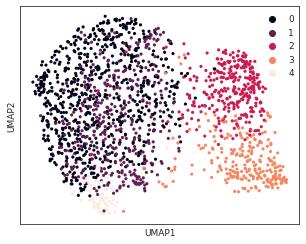

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.scatterplot(data_umap[:, 0], data_umap[:, 1], 
                s=10,
                hue=md['leiden'],
                palette='rocket',
                linewidth=0,
#                 palette='ocean', # tab20c
                legend='full', 
                ax=ax)
ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
fig.savefig(os.path.join(pfp, 'eval_umap_DTW_leiden.png'), bbox_inches='tight', dpi=600)

### compare to model embeddings

Using CNN for now

In [41]:
md_model = md_model.loc[evaluation.id, :] # re-order to match output
md_model = md_model.merge(pd.Series(evaluation.yhat.numpy(), name='actigraphy-GA', index=evaluation.id), left_index=True, right_index=True, how='left')
md_model['AbsErr'] = np.abs(md_model['GA'] - md_model['actigraphy-GA'])

In [42]:
out2_umap = weardtw.embed(evaluation.out2, metric='manhattan')

In [43]:
from scipy.spatial.distance import pdist, squareform
D_cnn = squareform(pdist(evaluation.out2.numpy(), metric='cityblock'))
membership_cnn = weardtw.leiden_clustering(D_cnn, gamma=0.5)


In [ ]:
# add clusters to md
md_model['leiden'] = membership_cnn

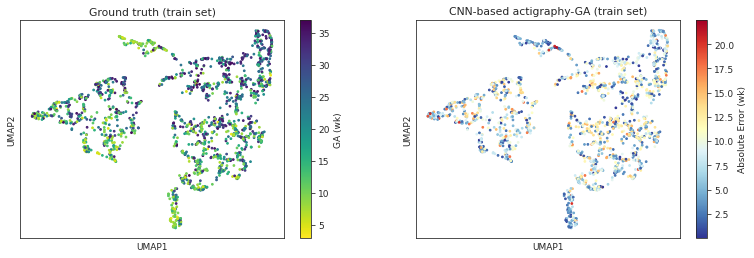

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
# ground truth
im = ax[0].scatter(out2_umap[:, 0], out2_umap[:, 1], 
                s=3,
                c=md_model['GA'], cmap='viridis_r')
fig.colorbar(im, label='GA (wk)', ax=ax[0])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('UMAP1')
ax[0].set_ylabel('UMAP2')
ax[0].set_title('Ground truth (train set)')

im = ax[1].scatter(out2_umap[:, 0], out2_umap[:, 1], 
                s=3,
                c=md_model['AbsErr'], cmap='RdYlBu_r')
fig.colorbar(im, label='Absolute Error (wk)', ax=ax[1])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel('UMAP1')
ax[1].set_ylabel('UMAP2')
ax[1].set_title('CNN-based actigraphy-GA (train set)')
fig.savefig(os.path.join(pfp, 'eval_umap_cnnfeats.png'), bbox_inches='tight', dpi=600)

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


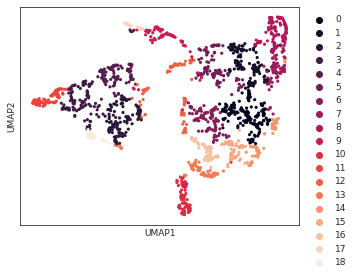

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.scatterplot(out2_umap[:, 0], out2_umap[:, 1], 
                s=10,
                hue=md_model['leiden'],
                palette='rocket',
                linewidth=0,
#                 palette='ocean', # tab20c
                legend='full', 
                ax=ax)
ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
fig.savefig(os.path.join(pfp, 'eval_umap_CNNfeat_leiden.png'), bbox_inches='tight', dpi=600)

### try to compare associations in md

In [71]:
targets = ['corticosteroids', 'ptb_37wks', 'prior_ptb_all', ]

In [102]:
# construct model data
def md_modeldata(metadata, target, covariates, split_id_key='record_id', train_frac=0.8):
    y = metadata[target] 
    idx = metadata[split_id_key].unique()
    idx_train = np.random.choice(idx, int(len(idx)*train_frac), replace=False)
    idx_test = [i for i in idx if i not in idx_train]
    idx_train = md[split_id_key].isin(idx_train).to_list()
    idx_test = md[split_id_key].isin(idx_test).to_list()
    y_train = y[idx_train].to_numpy(dtype=int)
    y_test = y[idx_test].to_numpy(dtype=int)
    X_train = covariates[idx_train, :].astype(np.float32)
    X_test = covariates[idx_test, :].astype(np.float32)
    return X_train, y_train, X_test, y_test

In [103]:
# covariates
dtw_clusters = np.zeros((len(membership), len(np.unique(membership))))
dtw_clusters[np.arange(len(membership)), membership] = 1.

cnn_clusters = np.zeros((len(membership_cnn), len(np.unique(membership_cnn))))
cnn_clusters[np.arange(len(membership_cnn)), membership_cnn] = 1.

In [104]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import balanced_accuracy_score

In [ ]:
print('For DTW clustering')
for i in targets:
    X_train, y_train, X_test, y_test = md_modeldata(md, i, dtw_clusters)
    lr = LogisticRegressionCV(cv=5)
    lr.fit(X_train, y_train)
    output = lr.predict(X_test)
    acc = balanced_accuracy_score(y_test, output)
    print('target: {}\tacc: {:.4f}'.format(i, acc))
    

For DTW clustering
target: corticosteroids	acc: 0.5000
target: ptb_37wks	acc: 0.5000
target: prior_ptb_all	acc: 0.5000


In [108]:
print('For CNN-based feature clustering')
for i in targets:
    X_train, y_train, X_test, y_test = md_modeldata(md_model, i, cnn_clusters)
    lr = LogisticRegressionCV(cv=5)
    lr.fit(X_train, y_train)
    output = lr.predict(X_test)
    acc = balanced_accuracy_score(y_test, output)
    print('target: {}\tacc: {:.4f}'.format(i, acc))
    

For CNN-based feature clustering
target: corticosteroids	acc: 0.5000
target: ptb_37wks	acc: 0.5000
target: prior_ptb_all	acc: 0.5000


## random clustering

In [54]:
# load data

model_fp = '/home/ngrav/scratch/wearables_model_zoo'

bst_trainer = os.path.join(model_fp, 'trainer_cnnl1l2rand_GA3.pkl')
bst_modelpkl = os.path.join(model_fp, '388-cnnl1l2rand_GA3.pkl')

# best CNN
_, md_random, trainer = weardtw.data_from_trainer(bst_trainer)

# call eval to get output, modify for return_hidden = True option
evaluation = weareval.eval_trained(trainer, split='train',
                                   modelpkl=bst_modelpkl,
                                   two_outputs=True)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [55]:
# md_model = md.loc[evaluation.id, :]
randout2_umap = weardtw.embed(evaluation.out2, metric='manhattan')

In [56]:
# add model output 
md_random = md_random.loc[evaluation.id, :] # reorder
md_random = md_random.merge(pd.Series(evaluation.yhat.numpy(), name='actigraphy-GA', index=evaluation.id), left_index=True, right_index=True, how='left')
md_random['AbsErr'] = np.abs(md_random['GA'] - md_random['actigraphy-GA'])

In [57]:
pfp = '/home/ngrav/project/wearables/results/'

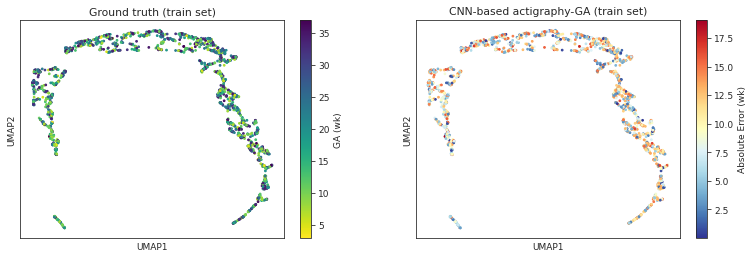

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
# ground truth
im = ax[0].scatter(randout2_umap[:, 0], randout2_umap[:, 1], 
                s=3,
                c=md_random['GA'], cmap='viridis_r')
fig.colorbar(im, label='GA (wk)', ax=ax[0])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('UMAP1')
ax[0].set_ylabel('UMAP2')
ax[0].set_title('Ground truth (train set)')

im = ax[1].scatter(randout2_umap[:, 0], randout2_umap[:, 1], 
                s=3,
                c=md_random['AbsErr'], cmap='RdYlBu_r')
fig.colorbar(im, label='Absolute Error (wk)', ax=ax[1])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel('UMAP1')
ax[1].set_ylabel('UMAP2')
ax[1].set_title('CNN-based actigraphy-GA (train set)')
fig.savefig(os.path.join(pfp, 'eval_umap_random.png'), bbox_inches='tight', dpi=600)

In [59]:
# cluster
from scipy.spatial.distance import pdist, squareform
D_random = squareform(pdist(evaluation.out2.numpy(), metric='cityblock'))
member_random = weardtw.leiden_clustering(D_random, gamma=0.5)
md_random['leiden'] = member_random

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


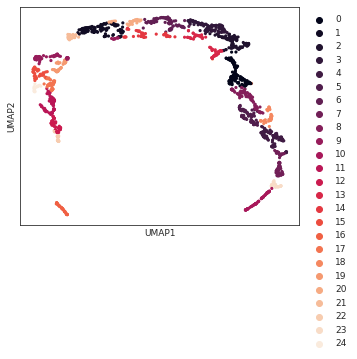

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.scatterplot(randout2_umap[:, 0], randout2_umap[:, 1], 
                s=10,
                hue=md_random['leiden'],
                palette='rocket',
                linewidth=0,
#                 palette='ocean', # tab20c
                legend='full', 
                ax=ax)
ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
fig.savefig(os.path.join(pfp, 'eval_umap_random_leiden.png'), bbox_inches='tight', dpi=600)

# cluster analysis

Place clusters in metadata df and analyze for differences

*data*: 
- `md`: from unsupervised DTW embedding
- `md_model`: from model embeddings
- `md_random`: from random model embeddings (label shuffling)

In [78]:
cat_targets = [k for k, v in trainer.data.data['voi'].items() if v[1]!='continuous']

In [84]:
voi = trainer.data.data['voi']

In [79]:
from sklearn.metrics.cluster import contingency_matrix

In [82]:
(md['leiden'] == 0).astyp

2280_22     True
2537_14     True
2440_34    False
1849_14     True
1604_11    False
           ...  
2469_24    False
1649_24     True
2409_7     False
1085_8     False
2464_14    False
Name: leiden, Length: 1729, dtype: bool

In [125]:
def sigvars_per_cluster(metadata, voi, cluster_key='leiden', bonferonni_crct=True):
    def pval2sigvarlist(sigvars_per_cluster_results, p_cutoff=0.001):
        dt = sigvars_per_cluster_results.loc[((sigvars_per_cluster_results < p_cutoff).sum(1)==1), :] < p_cutoff
        cluster_sig_vars = {}
        for col in dt.columns:
            cluster_sig_vars[col] = dt.loc[dt[col], col].index.to_list()
        return cluster_sig_vars
    from scipy.stats import chi2_contingency
    from scipy.stats import kruskal
    results = {c:{} for c in np.sort(metadata[cluster_key].unique())}
    # one-vs-rest scheme
    for i, c in enumerate(np.sort(metadata[cluster_key].unique())):
        metadata['cluster_part'] = (metadata[cluster_key] == c)
        for ii, v in enumerate(voi.keys()):
            if voi[v][1] == 'continuous':
                v_c = metadata.loc[metadata[cluster_key]==c, v]
                v_notc = metadata.loc[metadata[cluster_key]!=c, v]
                statistic, p = kruskal(v_c, v_notc)
            else:
                obs = metadata.groupby([v, 'cluster_part']).size().unstack(fill_value=0)
                chi2, p, dof, expected = chi2_contingency(obs) # Fischer's?
            results[c][v] = p / len(voi.keys()) if bonferonni_crct else p
    return pval2sigvarlist(pd.DataFrame(results))

In [126]:
dtw_clustanal = sigvars_per_cluster(md, voi)
model_clustanal = sigvars_per_cluster(md_model, voi)
rand_clustanal = sigvars_per_cluster(md_random, voi)

In [134]:
print('\nDTW: ')
for k in np.sort(list(dtw_clustanal.keys())):
    print('  {}:'.format(k), dtw_clustanal[k])
print('\nModel: ')
for k in np.sort(list(model_clustanal.keys())):
    print('  {}:'.format(k), model_clustanal[k])
print('\nRandom: ')
for k in np.sort(list(rand_clustanal.keys())):
    print('  {}:'.format(k), rand_clustanal[k])        



DTW: 
  0: ['asthma_yes___3', 'art_po2', 'ven_ph']
  1: ['rh']
  2: ['prior_ptb_all', 'asthma_yes___5', 'asthma_yes___7', 'abuse', 'regular_period1', 'edinb1_1trim', 'edinb2_1trim']
  3: ['asthma_yes___13', 'epidural', 'edinb5_1trim']
  4: ['ptb_37wks', 'art_excess', 'edinb3_1trim']

Model: 
  0: ['race', 'prior_ptb_all']
  1: ['stress6_1']
  2: []
  3: []
  4: ['drugs', 'deliv_mode', 'edinb5_1trim', 'edinb9_1trim']
  5: ['stress7_1', 'stress10_1', 'reset1']
  6: []
  7: ['afterlunch1']
  8: []
  9: ['maternal_del_weight']
  10: ['asthma_yes___3', 'asthma_yes___5', 'slp30_1trim']
  11: ['asthma_yes___18', 'asthma_yes___19', 'slpwake_1trim']
  12: ['abuse', 'stress9_1']
  13: ['fullterm_births', 'edinb6_1trim']
  14: ['cbc_mcv']
  15: []
  16: ['ghtn']
  17: ['preeclampsia']
  18: ['asthma_yes___2', 'passenger1', 'cartraffic1', 'edinb4_1trim']

Random: 
  0: ['surghx_none']
  1: []
  2: []
  3: ['asthma_yes___13']
  4: []
  5: ['asthma_yes___2']
  6: ['asthma_yes___7']
  7: ['asthma_ye

In [70]:
# calc odds_ratio
md.groupby('leiden').count().head()

,record_id,age_enroll,marital,gestage_by,insur,ethnicity,race,bmi_1vis,prior_ptb_all,fullterm_births,...,edinb4_1trim,edinb5_1trim,edinb6_1trim,edinb7_1trim,edinb8_1trim,edinb9_1trim,edinb10_1trim,GA,actigraphy-GA,AbsErr
leiden,,,,,,,,,,,,,,,,,,,,,
0,697,697,697,697,697,697,697,697,697,697,...,697,697,697,697,697,697,697,697,697,697
1,413,413,413,413,413,413,413,413,413,413,...,413,413,413,413,413,413,413,413,413,413
2,310,310,310,310,310,310,310,310,310,310,...,310,310,310,310,310,310,310,310,310,310
3,248,248,248,248,248,248,248,248,248,248,...,248,248,248,248,248,248,248,248,248,248
4,61,61,61,61,61,61,61,61,61,61,...,61,61,61,61,61,61,61,61,61,61


## dev pairwise DTW

**Observations**
- even with `n_jobs=32`, the sklearn implementation is slower than the scipy pdist

In [10]:
def pdtw(mat):
    return pdist(mat, lambda u, v: fastdtw.fastdtw(u, v)[0])

In [8]:
x.shape

torch.Size([64, 2, 10080])

In [11]:
# take only activity
x = x[:, 0, :]
x.shape

torch.Size([64, 10080])

In [14]:
tic = time.time()
d_mb = pdtw(x)
print('{:.0f}s'.format(time.time() - tic))

9s


In [16]:
# compare with paralellized scikit learn pairwise_distances 
from sklearn.metrics.pairwise import pairwise_distances

In [24]:
tic = time.time()
d_mb_sklearn = pairwise_distances(x, metric=lambda u, v: fastdtw.fastdtw(u, v)[0], n_jobs=32)
print('{:.0f}s'.format(time.time() - tic))

22s


In [22]:
print(d_mb.shape)
print(d_mb_sklearn.shape)

(2016,)
(64, 64)




## tshoot slow eval

attempts:
- tried to change num_workers of the dataloader to 1, in case there was some problem with the leaking. This did not solve the problem of the thing getting stuck after batch 1 loading
- tried changing pin_memory=False for the dataloader. This got through one additional batch loading but stopped on the third (test needs to go through ~11 batches)
- combination of both solved issue. After trying ablation again, getting rid of `dataloader.num_workers = 1` causes a pause. Then changing `dataloader.pin_memory = False` but keeping `dataloader.num_woerkers = 1` makes the eval fast again. SO, the issue was indeed the num_workers